# End-to-End Multi-Class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

### 1. Problem

Identifying the breed of a dog given an image of a dog.


### 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

### 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

### 4. Features

Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

**Get our workspace ready**

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [3]:
# Import TensorFlow and TensorFlow hub into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:",tf.__version__)
print("TF Hub version:",hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.3.0
TF Hub version: 0.8.0
GPU available


### Getting our data ready(turning into Tensors)
Turning our images into Tensors (numerical representations).

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog-Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     2197f4bff731d1de02ee0dfef5f4c860  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


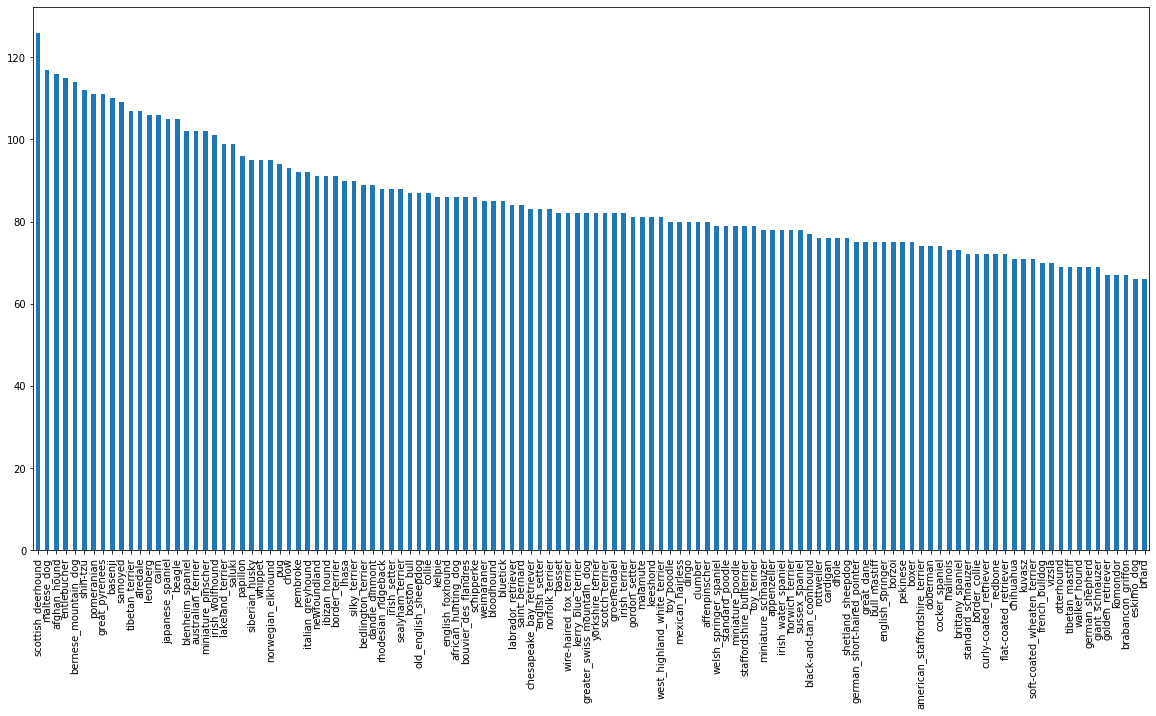

In [6]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize =(20,10));

In [7]:
# The median number of images per class
labels_csv["breed"].value_counts().median()

82.0

In [ ]:
# Let's view an image
from IPython.display import Image
# Image("/content/drive/My Drive/Dog-Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

**Getting images and their labels**


In [10]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# Create pathnames from image ID's
filenames = ["/content/drive/My Drive/Dog-Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 5
filenames[:5]

['/content/drive/My Drive/Dog-Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Dog-Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Dog-Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Dog-Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Dog-Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [12]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/My Drive/Dog-Vision/train")) == len(filenames):
  print("Filenames match actual amount of files")
else:
  print("Filenames don't match actual amount of files")

Filenames match actual amount of files


In [ ]:
# Check the images one more time
# Image(filenames[9000])

In [13]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [14]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches the number of filenames 
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames")

Number of labels matches number of filenames


In [17]:
#  Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
unique_breeds[:10]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle'], dtype=object)

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [21]:
# Turn every labels into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
# Turning boolean array into integer
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) #  index where labels occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


**Creating our own validation set**

Since the dataset from Kaggle doesn't come with a validation set,we're going to create our own

In [24]:
# Setup X & y variables 
X = filenames 
y = boolean_labels

In [25]:
len(filenames)

10222

We're going to start off experimenting with 1000 images and increase as needed.

In [26]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000,max:10000,step:1000}

In [27]:
# Split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],
                                               y[:NUM_IMAGES],
                                               test_size = 0.2,
                                               random_state = 42)
len(X_train),len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

In [28]:
X_train[:3],y_train[:2]

(['/content/drive/My Drive/Dog-Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/My Drive/Dog-Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/My Drive/Dog-Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, 

**Prepocessing Images(turning images into Tensors)**

To preprocess our images into Tensors we're going to write a function which does a few things

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable. 'image'
3. Turn our image (a jpg.) into Tensors.
4. Normalize our image(convert color channel values from 0-255 to 0-1)
5. Resize the image to be a shape of(224,224)
6. Return the modified image


In [31]:
# Convert image to NumPy array 
from matplotlib.pyplot import imread
image = imread(filenames[5])
image.shape

(375, 500, 3)

In [32]:
image.max(),image.min()

(255, 0)

In [33]:
image[:2]

array([[[143, 136, 144],
        [141, 134, 142],
        [143, 136, 144],
        ...,
        [ 82,  73,  74],
        [ 85,  76,  77],
        [ 79,  70,  71]],

       [[147, 140, 148],
        [140, 133, 141],
        [130, 123, 131],
        ...,
        [123, 117, 119],
        [125, 119, 121],
        [120, 114, 116]]], dtype=uint8)

In [34]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[143, 136, 144],
        [141, 134, 142],
        [143, 136, 144],
        ...,
        [ 82,  73,  74],
        [ 85,  76,  77],
        [ 79,  70,  71]],

       [[147, 140, 148],
        [140, 133, 141],
        [130, 123, 131],
        ...,
        [123, 117, 119],
        [125, 119, 121],
        [120, 114, 116]]], dtype=uint8)>

In [35]:
# Define image size 
IMG_SIZE = 224
# Create a function fro preprocessing images 
def process_image(image_path,img_size =IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file 
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels(Red,Green,Blue)
  image = tf.image.decode_jpeg(image,channels = 3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)
  # Resize the image to our desired value(224,224)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
  return image

**Turning our data into batches**

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).

In [36]:
# Create a simple function to return a tuple(image,label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of(image,lable).
  """
  image = process_image(image_path)
  return image,label

In [37]:
# Demo of above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: (image, label), let's make a function to turn all of our data (X & y) into batches!

In [38]:
# Define the batch size, 32 (General Default)
BATCH_SIZE = 32
# Create a function to turn data into batches
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data = False,test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data :
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepath (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X))

    # Create (image,label) tuples (this also turns image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the traning data into batches 
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [39]:
# Create training and validation data batches 
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data = True)

Creating training data batches...
Creating validation data batches...


In [40]:
# Check out the different attributes of our data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches 

In [41]:
import matplotlib.pyplot as plt
# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize = (10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows,5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines of
    plt.axis("off")

In [42]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

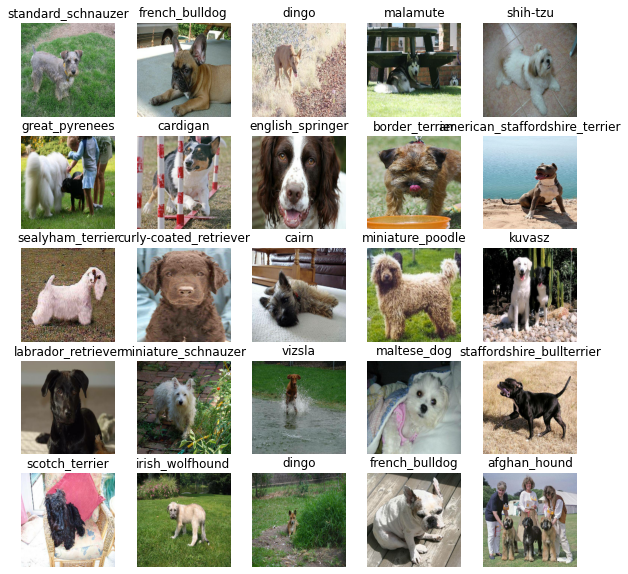

In [43]:
# Now let's visualize the data in a training batch
train_images,train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

In [ ]:
# # Now let's visualize our validation set
# val_images, val_labels = next(val_data.as_numpy_iterator())
# show_25_images(val_images, val_labels)

### Building a model

Before we build a model, there are a few things we need to define:

* The input shape (our image shape,in the form of Tensors) to our model.
* The output shape (image labels,in the form of Tensors) of our model.
* The URL of the model we want yo use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [44]:
# Setup input shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3] # Batch, height, width, color channels
# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)
# Setup our model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [45]:
INPUT_SHAPE

[None, 224, 224, 3]

Now we've got out inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model.

Create a function which:

* Takes the imput shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model(says it should be evaluated and improved).
* Builds the model(tells the model the input shape it'll be getting.)
* Returns the model

In [46]:
# Create a function which builds a Keras model
def create_model(input_shape = INPUT_SHAPE,output_shape = OUTPUT_SHAPE,model_url = MODEL_URL):
  print("Building model with:",MODEL_URL)

  # Setup the model layers 
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL),# Layer 1 (input layer)
                               tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                                                     activation ="softmax") # Layer 2 (Output layer)
  ])
  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )
  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [47]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating Callbacks

Callbacks are helper function a model can use during training to do such things as save the progress. Check it's progress or stop traning early if a model stop improving. I'll create two callbacks, one for TensorBoaard which helps track our models progress and another for early stopping which prevents our model from traning for too long.

### TensorBoard Callback

To setup a TensorBoard callback, I need to do 3 things:

1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function
3. Visualize our models traning logs with the %tensorboard function 

In [48]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [49]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/My Drive/Dog-Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [50]:
# Create early stopping callback 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                 patience =3)

### Training a model (on subset data)

My first model is only going to train on 1000 images, to make sure everything is working.

In [51]:
NUM_EPOCHS = 100 #@param {type:"slider",min:10,max:100,step:10}

In [52]:
# Check to make sure we'll still running on a GPU
print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function which trains a model

* Create a model using create_model()
* Setup TensorBoard callback using create_tensorboard_callback()
* Call fit() function on our model passing it the training data, validation data, number of epoch to train for (NUM_EPOCHS) and the callbacks I'd like to use 
* Return the model

In [53]:
# Build a function to train and return a trained model 
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()
  # Create new Tensorboard session everytime we trained a model
  tensorboard = create_tensorboard_callback()
  # Fit the model to the data passing it the callback we created
  model.fit(x=train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks=[tensorboard,early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
# model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 1/25 [>.............................] - ETA: 0s - loss: 5.7201 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


 2/25 [=>............................] - ETA: 3s - loss: 5.5518 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1299s vs `on_train_batch_end` time: 0.2136s). Check your callbacks.


25/25 [==============================] - 5s 203ms/step - loss: 4.5297 - accuracy: 0.1025 - val_loss: 3.5209 - val_accuracy: 0.3000
Epoch 2/100
25/25 [==============================] - 5s 187ms/step - loss: 1.6221 - accuracy: 0.6988 - val_loss: 2.2897 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 5s 187ms/step - loss: 0.5641 - accuracy: 0.9400 - val_loss: 1.7280 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 5s 184ms/step - loss: 0.2517 - accuracy: 0.9912 - val_loss: 1.5497 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 5s 185ms/step - loss: 0.1443 - accuracy: 0.9962 - val_loss: 1.4632 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 5s 186ms/step - loss: 0.0997 - accuracy: 1.0000 - val_loss: 1.4102 - val_accuracy: 0.6500
Epoch 7/100
25/25 [==============================] - 5s 188ms/step - loss: 0.0751 - accuracy: 1.0000 - val_loss: 1.3869 - val_accuracy: 0.6500
Epoch 8/100

### Checking the TensorBoard logs
The TensorBoard function (%tensorboard) will access the logs directory we created earlier and visualize its contents.

In [ ]:
# %tensorboard --logdir /content/drive/My\ Drive/Dog\ Vision/logs  /content/drive/My Drive/Dog-Vision/logs

### Making and evaluating predictions using trained model

In [54]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [132]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data,verbose =1)
predictions

7/7 [==============================] - 1s 106ms/step


array([[2.6233702e-03, 2.0067528e-04, 5.1302585e-04, ..., 4.8955809e-04,
        1.1052133e-04, 3.6564439e-03],
       [5.6366529e-03, 1.0402307e-03, 1.0593331e-02, ..., 3.6070481e-04,
        1.9204256e-03, 1.3835677e-04],
       [9.3593026e-06, 1.8117857e-05, 3.8863791e-06, ..., 2.1020631e-05,
        4.3039781e-05, 5.4069824e-04],
       ...,
       [7.5062303e-06, 4.0489504e-05, 5.0754472e-05, ..., 1.7221140e-05,
        5.2543002e-04, 6.8086832e-05],
       [2.6832563e-03, 5.9471629e-05, 9.8842647e-05, ..., 1.5550399e-04,
        1.4538686e-04, 4.8106438e-03],
       [1.6711331e-04, 7.3541141e-06, 2.4909074e-03, ..., 8.4414822e-04,
        4.7337773e-04, 3.7378701e-05]], dtype=float32)

In [129]:
predictions[0], len(predictions[0])

(array([2.62337015e-03, 2.00675277e-04, 5.13025851e-04, 1.45366594e-05,
        2.02049356e-04, 1.63809727e-05, 6.02807477e-03, 3.49269336e-04,
        1.21879959e-04, 9.02779924e-04, 3.39504186e-04, 6.53260940e-05,
        1.83793280e-04, 3.78492296e-05, 2.78627820e-04, 1.66695652e-04,
        2.43802424e-05, 8.51102248e-02, 1.14092036e-05, 5.79831176e-05,
        1.19706686e-03, 5.63633454e-04, 1.12891203e-05, 5.29812765e-04,
        1.25887062e-04, 5.52692334e-04, 4.68987465e-01, 4.36250593e-05,
        1.95439934e-04, 3.23910819e-04, 1.37748182e-04, 7.72267755e-04,
        3.36873258e-04, 1.72185810e-05, 5.04638738e-05, 2.19026376e-02,
        4.52413078e-05, 4.05253581e-04, 1.56980877e-05, 3.55651791e-05,
        2.13744468e-03, 1.96800502e-05, 2.12420855e-04, 6.94063638e-05,
        2.26745742e-05, 1.78186136e-04, 1.55089274e-05, 2.01125324e-04,
        4.84630931e-04, 6.05594287e-05, 1.30425571e-04, 3.52434399e-05,
        1.58235940e-04, 1.81478536e-04, 6.56677148e-05, 1.491542

In [80]:
# First prediction
index = 5
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.31127490e-06 1.54836289e-05 6.33397030e-06 1.42225006e-03
 3.37725542e-05 6.16045372e-06 7.03490923e-06 5.51230587e-05
 3.83988110e-04 4.75649131e-06 9.80189979e-01 5.09325837e-05
 2.04569533e-05 6.52209710e-05 5.50663681e-05 8.26378178e-04
 7.29758221e-06 1.37513980e-05 6.86070234e-06 2.45194497e-05
 7.44246472e-06 1.48299177e-05 4.91962164e-05 2.92334244e-05
 1.13254129e-04 1.95960947e-05 3.99199280e-06 2.32771763e-05
 2.13248102e-04 5.30024590e-06 3.27762950e-06 3.65520857e-04
 1.22146366e-05 3.41286432e-05 1.39455311e-04 7.83233336e-05
 1.89575003e-05 2.71813278e-05 7.80623304e-05 1.19053897e-04
 6.05356436e-05 3.51461786e-05 8.90082811e-05 2.11762472e-05
 7.44998533e-06 2.16026874e-05 7.38998597e-06 5.30538964e-04
 3.70802991e-05 4.39717514e-05 6.14326382e-06 4.91153514e-05
 5.30241705e-05 1.91088820e-05 1.94578342e-06 5.52027952e-04
 1.39365084e-05 1.02649959e-04 1.73338398e-04 3.95181356e-04
 4.36697701e-05 1.43304678e-05 7.80994560e-06 3.09978077e-06
 1.02536473e-03 8.842669

In [81]:
unique_breeds[10]

'bedlington_terrier'

**Notice**: Prediction probabilities are also known as confidence levels.

In [66]:
# Turn prediction probabilities into their respective label 
def get_pred_label(prediction_probabilities):
  """
  Turn an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'bedlington_terrier'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [82]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Take a batched dataset of(image,label) Tensors and returns seperate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images,labels
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0],val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

I'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. 
* Convert the prediction probabilities to a predicted label. 
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. 

In [125]:
def plot_pred(prediction_probabilities,labels,images,n=1):
  """
  View the predictions, ground truth and image for sample n
  """
  pred_prob,true_label,image = prediction_probabilities[n],labels[n],images[n]

  # Get the pred label
  pred_label=get_pred_label(pred_prob)
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  # Change the color of the title depending on if the predictions is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                     np.max(pred_prob)*100,
                                     true_label),
                                    color = color)

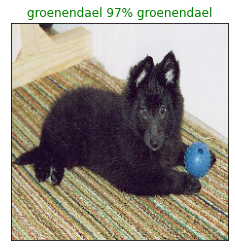

In [142]:
plot_pred(prediction_probabilities = predictions
          ,labels = val_labels,
          images = val_images,
          n=77)


Now I've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer 
* Find the prediction using get_pred_label() 
Find the top 10:
  * Prediction probabilities indexes 
  * Prediction probabilities values 
  * Prediction labels 

* Plot the top 10 prediction probability values and labels, coloring the true label green 

In [123]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

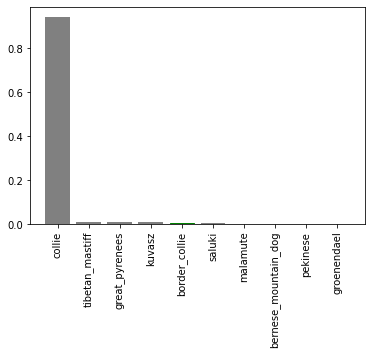

In [124]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

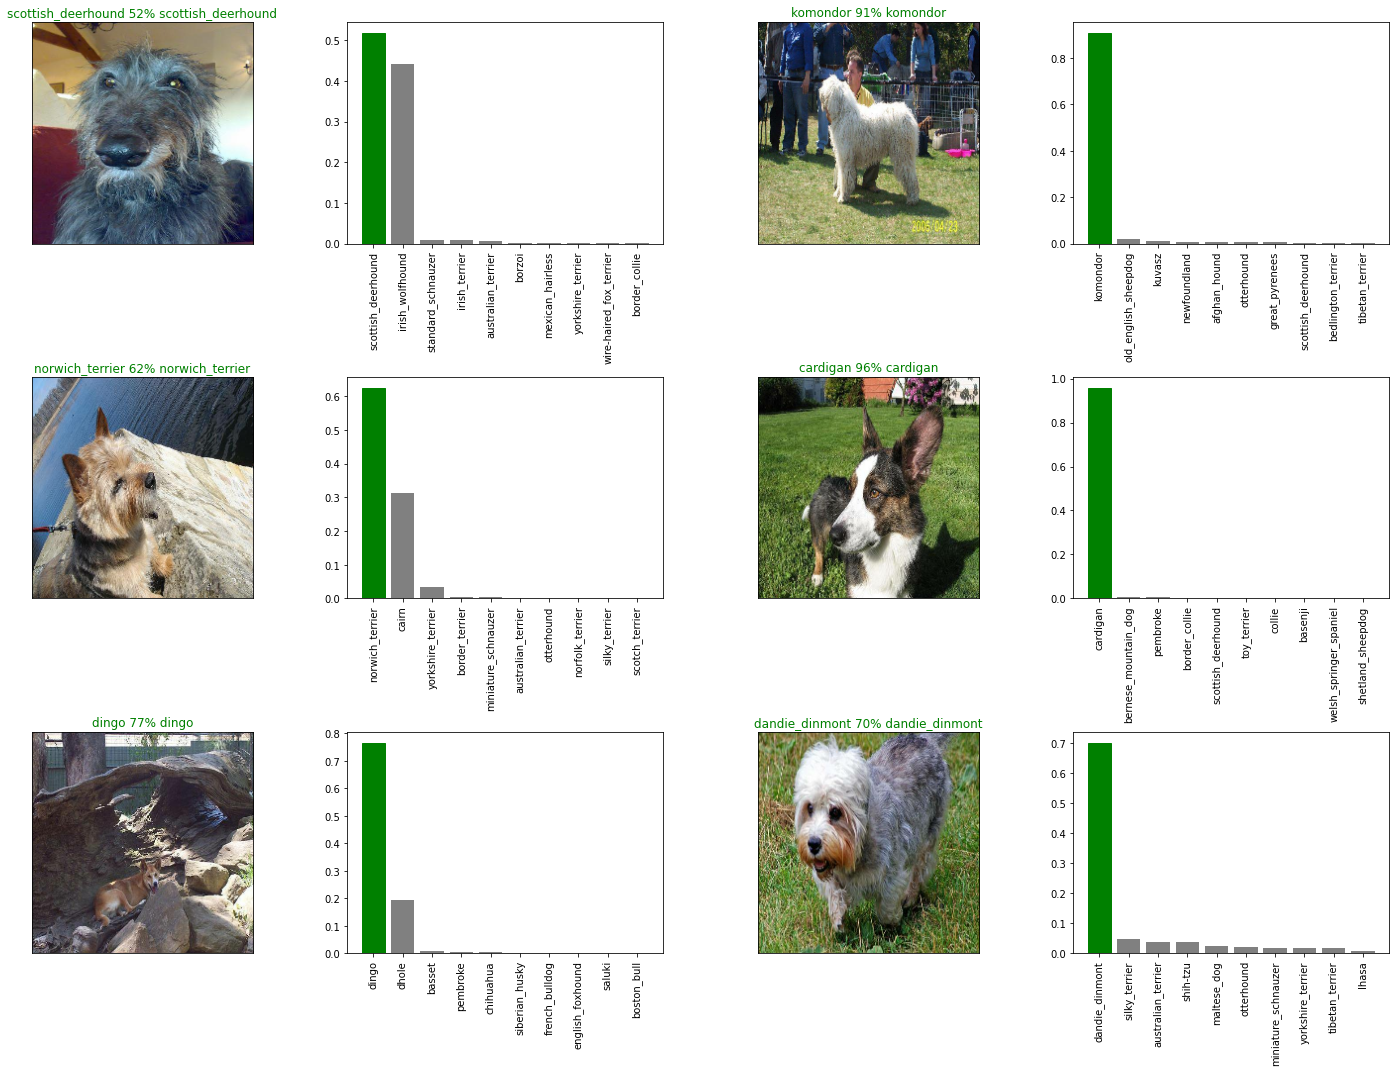

In [143]:
# Let's check out a few prediction and their different values
i_multiplier = 25
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize = (10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

###Saving and reloding a trained model

In [72]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/My Drive/Dog-Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [71]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model 10 100 images
# save_model(model,suffix ="1000-images-mobilenetv2-Adam")

Saving model to: /content/drive/My Drive/Dog-Vision/models/20200813-07251597303532-1000-images-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog-Vision/models/20200813-07251597303532-1000-images-mobilenetv2-Adam.h5'

In [74]:
# Load a trained model
loaded_1000_image_model = load_model("/content/drive/My Drive/Dog-Vision/models/20200813-07241597303440-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: /content/drive/My Drive/Dog-Vision/models/20200813-07241597303440-1000-images-mobilenetv2-Adam.h5


In [87]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 84ms/step - loss: 1.2665 - accuracy: 0.6800


[1.2664788961410522, 0.6800000071525574]

In [76]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 93ms/step - loss: 1.2665 - accuracy: 0.6800


[1.2664788961410522, 0.6800000071525574]

### Training a big dog model (on the full data)

In [88]:
len(X),len(y)

(10222, 10222)

In [89]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creating training data batches...


In [90]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [91]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [92]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so I can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor ="accuracy",
                                                            patience =3)

In [ ]:
#  Fit the full model to the full data
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 7257s 23s/step - loss: 1.3388 - accuracy: 0.6717
Epoch 2/100
320/320 [==============================] - 47s 146ms/step - loss: 0.4045 - accuracy: 0.8816
Epoch 3/100
320/320 [==============================] - 47s 146ms/step - loss: 0.2390 - accuracy: 0.9345
Epoch 4/100
320/320 [==============================] - 45s 141ms/step - loss: 0.1566 - accuracy: 0.9610
Epoch 5/100
320/320 [==============================] - 45s 140ms/step - loss: 0.1071 - accuracy: 0.9777
Epoch 6/100
320/320 [==============================] - 45s 140ms/step - loss: 0.0789 - accuracy: 0.9862
Epoch 7/100
320/320 [==============================] - 44s 139ms/step - loss: 0.0583 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 44s 137ms/step - loss: 0.0464 - accuracy: 0.9940
Epoch 9/100
320/320 [==============================] - 45s 140ms/step - loss: 0.0385 - accuracy: 0.9961
Epoch 10/100
320/320 [==============================] - 45s 141m

In [ ]:
# save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: /content/drive/My Drive/Dog-Vision/models/20200813-10061597313201-full-image-set-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog-Vision/models/20200813-10061597313201-full-image-set-mobilenetv2-Adam.h5'

In [120]:
# Load in the full model
loaded_full_model = load_model("/content/drive/My Drive/Dog-Vision/models/20200813-10061597313201-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: /content/drive/My Drive/Dog-Vision/models/20200813-10061597313201-full-image-set-mobilenetv2-Adam.h5


### Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor Bacthes, to make predictions on the test data. I'll have to get it into same format.

To make predictions on the test data, we'll:

* Get the test image filenames. 
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since the test data doesn't have labels). 
* Make a predictions array by passing the test batches to the predict() method called on our model.


In [135]:
# Load test image filenames
test_path = "/content/drive/My Drive/Dog-Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Dog-Vision/test/e9d1478e035f22b0cf94be580d620f80.jpg',
 '/content/drive/My Drive/Dog-Vision/test/efc4b489fc15ff97a50536c71029a8b1.jpg',
 '/content/drive/My Drive/Dog-Vision/test/efac70ee513c40265966b89d715f183e.jpg',
 '/content/drive/My Drive/Dog-Vision/test/f4af276965865188983afcbb5fca9cc2.jpg',
 '/content/drive/My Drive/Dog-Vision/test/ef4c9b0875ec51068b2720a01fa36b65.jpg',
 '/content/drive/My Drive/Dog-Vision/test/f285b753c96949769c745ec0f90b2253.jpg',
 '/content/drive/My Drive/Dog-Vision/test/eaa28b3163bb05afd07117ec4c6bb059.jpg',
 '/content/drive/My Drive/Dog-Vision/test/f30e9a91acfb7e0fd1a3f9b91ca36914.jpg',
 '/content/drive/My Drive/Dog-Vision/test/ef3cceaaed2906916a76290fe0bd2b32.jpg',
 '/content/drive/My Drive/Dog-Vision/test/f2dd8cf1ced495252a890e6633b65018.jpg']

In [138]:
len(test_filenames)

10357

In [136]:
# Create test data batch
test_data = create_data_batches(test_filenames,test_data = True)

Creating test data batches...


In [137]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>


**Notice**: Calling predict() on our full model and passing it the test data batch will take a long time to run (about a ~1hr). This is because we have to process ~10,000+ images and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [108]:
# Make predictions on test data batch using the loaded full model
# test_predictions = loaded_full_model.predict(test_data,verbose = 1)

In [109]:
# Save predictions (NumPy array) to csv file (for access later)
#np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predctions, delimiter=",")

In [110]:
# Load predictions (NumPy array) from csv file
# test_predictions = np.loadtxt("/content/drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

### Making predictions on custom images

To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [166]:
# Get custom image filepath
custom_path = "/content/drive/My Drive/Dog-Vision/my_dog_photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [167]:
custom_image_paths

['/content/drive/My Drive/Dog-Vision/my_dog_photos/dog-photo-2.jpeg',
 '/content/drive/My Drive/Dog-Vision/my_dog_photos/dog-photo-4.jpeg',
 '/content/drive/My Drive/Dog-Vision/my_dog_photos/dog-photo-5.jpeg',
 '/content/drive/My Drive/Dog-Vision/my_dog_photos/dog-photo-1.jpeg',
 '/content/drive/My Drive/Dog-Vision/my_dog_photos/dog-photo-3.jpeg']

In [168]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [169]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [170]:
custom_preds.shape

(5, 120)

In [171]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['lakeland_terrier',
 'toy_poodle',
 'toy_poodle',
 'golden_retriever',
 'labrador_retriever']

In [172]:
# Get custom images 
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

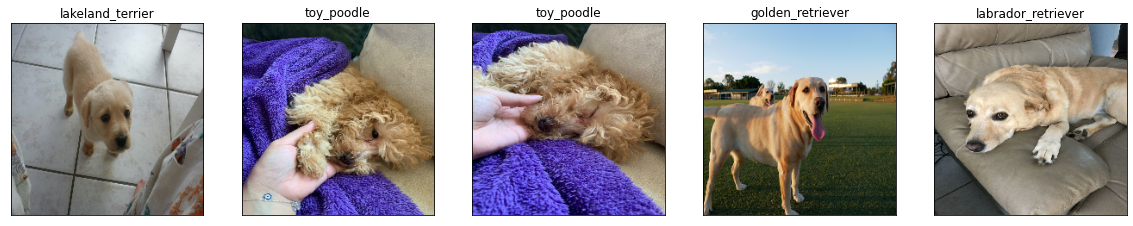

In [174]:
# Check custom image predictions
plt.figure(figsize=(20, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)